# Machine Learning for Basketball Memorabilia Investments
We will use real data on past basketball players to use ML to inform memorabilia investment decisions.

We are provided with data on past players that includes 27 different predictors/attributes on each player. Note that the attribute names are often abbreviated and the complete list is included at the end of this notebook.

We will use the historical data set, Hall-of-fame-train.arff (495 players), to build a classification model predicting whether or not a given player will be inducted (and the probability thereof). We will then apply our model to select players to invest in. The goal of this assignment is to develop hands-on experience in developing and evaluating machine learning models to inform interventions (investment decisions in this case) and to maximize profitability.

The data set includes a target variable (i.e., the class) which indicates whether or not the player has been inducted to the hall of fame. Note that in this data set, we assume that a player who has not been inducted 45.4 years after retirement, will not be inducted. The target variable is binary and has value 1 if the player has been inducted or 0 otherwise. Note that the data includes the actual target variable value for each player.

## 1. Read in Libraries and NBA data

In [1]:
!pip install liac-arff


[notice] A new release of pip is available: 23.0 -> 23.1.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [2]:
# import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
import arff

In [3]:
# get data from online
df_arff = requests.get('https://utexas.box.com/shared/static/u8s1nl2c8b3ijv94z7npg7jl0drml5u0.arff')

# read as arff file
df_arff = arff.load(df_arff.text)
col_val = [attribute[0] for attribute in df_arff['attributes']]

# transform arff file into pandas dataframe
new_df = pd.DataFrame(df_arff['data'], columns = col_val)
meta = df_arff['attributes']

def clean_df(df):
  cols = list(df.columns)
  for col in cols:
    try:
      df = df.replace({col: {'1': True, '0': False}})
    except:
      pass
    pass
  return df

new_df = clean_df(new_df)
new_df = pd.get_dummies(new_df)

In [4]:
new_df.head()

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,firstSeason,lastSeason,careerEnded,yrsRetired2004,class,league_A,league_N,Position_C,Position_F,Position_G
0,408.0,9825.0,5232.0,476.0,824.0,1300.0,866.0,265.0,175.0,700.0,...,1982.0,1990.0,1.0,14.0,False,0,1,0,0,1
1,51.0,0.0,587.0,0.0,0.0,0.0,158.0,0.0,0.0,0.0,...,1949.0,1949.0,1.0,55.0,False,0,1,0,0,1
2,265.0,0.0,1712.0,0.0,0.0,72.0,311.0,0.0,0.0,0.0,...,1946.0,1950.0,1.0,54.0,False,0,1,0,0,1
3,133.0,2587.0,992.0,55.0,198.0,253.0,291.0,123.0,14.0,207.0,...,2003.0,2004.0,0.0,0.0,False,0,1,0,0,1
4,8.0,28.0,7.0,0.0,2.0,2.0,0.0,0.0,0.0,1.0,...,2004.0,2004.0,0.0,0.0,False,0,1,0,0,1


In [5]:
new_df.iloc[0]

games              408.0
minutes           9825.0
pts               5232.0
offReb             476.0
defReb             824.0
reb               1300.0
asts               866.0
stl                265.0
blk                175.0
turnover           700.0
pf                1214.0
fga               4074.0
fgm               2031.0
fta               1495.0
ftm               1125.0
tpa                153.0
tpm                 45.0
totalSeasons         9.0
firstSeason       1982.0
lastSeason        1990.0
careerEnded          1.0
yrsRetired2004      14.0
class              False
league_A               0
league_N               1
Position_C             0
Position_F             0
Position_G             1
Name: 0, dtype: object

## 2. Exploring the Data

**2.1 Building, Evaluating, and Comparing Different Machine Learning Models**

Note: this section can take around 100 minutes to run.

In [6]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.neighbors import KNeighborsClassifier
# GridSearchCV is used to find the best parameters for a model
from sklearn.model_selection import GridSearchCV
# StratifiedKFold is used to split the data into folds for cross validation
# The folds are balanced by class, removing the possibility of having a fold with imbalanced classes
from sklearn.model_selection import StratifiedKFold



# Split the data into features and target
# Don't need to split the data into training and testing sets yet because we are already doing 10-fold cross validation
# We will split the data into training and testing sets later on to mimic a real-world scenario since we don't have a given testing set
# A test set should still be held out for final evaluation, but the validation set is no longer needed when doing CV
X = new_df.drop(columns='class')
y = new_df['class']



# Build and compare the results of different models using 10-fold cross validation (with results displayed for each)
# Test out different parameters of each model to try and generate the best result
# We use StratifiedKFold so we can yield the same results every time with GridSearchCV
folds = StratifiedKFold(n_splits=10, random_state=3, shuffle=True)
classification_accuracies = {}
roc_auc_scores = {}

In [7]:
# Decision Tree
dt = DecisionTreeClassifier(random_state=3)
# Using GridSearchCV to find the best parameters for the decision tree
dt_params = {'criterion': ['gini', 'entropy'], 'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 
             'max_depth': [2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]}
# Using GridSearchCV to find the best parameters for the decision tree based on the classificaiton accuracy
dt_grid = GridSearchCV(dt, dt_params, cv=folds, scoring='accuracy')
dt_grid.fit(X, y)
print('Best parameters for decision tree if using classification accuracy as performance metrics: ', dt_grid.best_params_)
print('Best classification accuracy for decision tree: ', dt_grid.best_score_)
classification_accuracies['Decision Tree'] = dt_grid.best_score_
# Using GridSearchCV to find the best parameters for the decision tree based on the ROC AUC
dt_grid_roc = GridSearchCV(dt, dt_params, cv=folds, scoring='roc_auc')
dt_grid_roc.fit(X, y)
print('Best parameters for decision tree if using ROC AUC as performance metrics: ', dt_grid_roc.best_params_)
print('Best ROC AUC for decision tree: ', dt_grid_roc.best_score_)
roc_auc_scores['Decision Tree'] = dt_grid_roc.best_score_
print()

Best parameters for decision tree if using classification accuracy as performance metrics:  {'criterion': 'gini', 'max_depth': 5, 'max_features': 0.2, 'min_samples_leaf': 2, 'min_samples_split': 6}
Best classification accuracy for decision tree:  0.9736734693877551
Best parameters for decision tree if using ROC AUC as performance metrics:  {'criterion': 'gini', 'max_depth': 4, 'max_features': 0.6, 'min_samples_leaf': 7, 'min_samples_split': 2}
Best ROC AUC for decision tree:  0.953111111111111



In [8]:
# Multinomial Naive Bayes
mnb = MultinomialNB(force_alpha=True)
# Using GridSearchCV to find the best parameters for the multinomial naive bayes
mnb_params = {'alpha': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
# Using GridSearchCV to find the best parameters for the multinomial naive bayes based on the classificaiton accuracy
mnb_grid = GridSearchCV(mnb, mnb_params, cv=folds, scoring='accuracy')
mnb_grid.fit(X, y)
print('Best parameters for multinomial naive bayes if using classification accuracy as performance metrics: ', mnb_grid.best_params_)
print('Best classification accuracy for multinomial naive bayes: ', mnb_grid.best_score_)
classification_accuracies['Multinomial Naive Bayes'] = mnb_grid.best_score_
# Using GridSearchCV to find the best parameters for the multinomial naive bayes based on the ROC AUC
mnb_grid_roc = GridSearchCV(mnb, mnb_params, cv=folds, scoring='roc_auc')
mnb_grid_roc.fit(X, y)
print('Best parameters for multinomial naive bayes if using ROC AUC as performance metrics: ', mnb_grid_roc.best_params_)
print('Best ROC AUC for multinomial naive bayes: ', mnb_grid_roc.best_score_)
roc_auc_scores['Multinomial Naive Bayes'] = mnb_grid_roc.best_score_
print()

Best parameters for multinomial naive bayes if using classification accuracy as performance metrics:  {'alpha': 0.01}
Best classification accuracy for multinomial naive bayes:  0.8907346938775509
Best parameters for multinomial naive bayes if using ROC AUC as performance metrics:  {'alpha': 0.01}
Best ROC AUC for multinomial naive bayes:  0.9007222222222222



In [9]:
# K Nearest Neighbors
knn = KNeighborsClassifier()
# Using GridSearchCV to find the best parameters for the K Nearest Neighbors
knn_params = {'n_neighbors': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}
# Using GridSearchCV to find the best parameters for the K Nearest Neighbors based on the classificaiton accuracy
knn_grid = GridSearchCV(knn, knn_params, cv=folds, scoring='accuracy')
knn_grid.fit(X, y)
print('Best parameters for K Nearest Neighbors if using classification accuracy as performance metrics: ', knn_grid.best_params_)
print('Best classification accuracy for K Nearest Neighbors: ', knn_grid.best_score_)
classification_accuracies['K Nearest Neighbors'] = knn_grid.best_score_
# Using GridSearchCV to find the best parameters for the K Nearest Neighbors based on the ROC AUC
knn_grid_roc = GridSearchCV(knn, knn_params, cv=folds, scoring='roc_auc')
knn_grid_roc.fit(X, y)
print('Best parameters for K Nearest Neighbors if using ROC AUC as performance metrics: ', knn_grid_roc.best_params_)
print('Best ROC AUC for K Nearest Neighbors: ', knn_grid_roc.best_score_)
roc_auc_scores['K Nearest Neighbors'] = knn_grid_roc.best_score_
print()

Best parameters for K Nearest Neighbors if using classification accuracy as performance metrics:  {'algorithm': 'auto', 'n_neighbors': 5, 'weights': 'uniform'}
Best classification accuracy for K Nearest Neighbors:  0.9676326530612245
Best parameters for K Nearest Neighbors if using ROC AUC as performance metrics:  {'algorithm': 'auto', 'n_neighbors': 8, 'weights': 'distance'}
Best ROC AUC for K Nearest Neighbors:  0.9404444444444444



In [10]:
# Bagging with Decision Tree as base estimator
# Best decision tree with the best parameters
dt_best = DecisionTreeClassifier(criterion='gini', max_depth=4, max_features=0.6, min_samples_leaf=7, min_samples_split=2, random_state=3)
bag = BaggingClassifier(estimator=dt_best, n_estimators=100, random_state=3)
# Using GridSearchCV to find the best parameters for the bagging with decision tree as base estimator
bag_params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_samples': [0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
# Using GridSearchCV to find the best parameters for the bagging with decision tree as base estimator based on the classificaiton accuracy
bag_grid = GridSearchCV(bag, bag_params, cv=folds, scoring='accuracy')
bag_grid.fit(X, y)
print('Best parameters for bagging with decision tree as base estimator if using classification accuracy as performance metrics: ', bag_grid.best_params_)
print('Best classification accuracy for bagging with decision tree as base estimator: ', bag_grid.best_score_)
classification_accuracies['Bagging with Decision Tree as Base Estimator'] = bag_grid.best_score_
# Using GridSearchCV to find the best parameters for the bagging with decision tree as base estimator based on the ROC AUC
bag_grid_roc = GridSearchCV(bag, bag_params, cv=folds, scoring='roc_auc')
bag_grid_roc.fit(X, y)
print('Best parameters for bagging with decision tree as base estimator if using ROC AUC as performance metrics: ', bag_grid_roc.best_params_)
print('Best ROC AUC for bagging with decision tree as base estimator: ', bag_grid_roc.best_score_)
roc_auc_scores['Bagging with Decision Tree as Base Estimator'] = bag_grid_roc.best_score_
print()

# Bagging with Multinomial Naive Bayes as base estimator
# Best multinomial naive bayes with the best parameters
mnb_best = MultinomialNB(force_alpha=True, alpha=0.01)
bag_mnb = BaggingClassifier(estimator=mnb_best, n_estimators=100, random_state=3)
# Using GridSearchCV to find the best parameters for the bagging with multinomial naive bayes as base estimator
bag_mnb_params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
# Using GridSearchCV to find the best parameters for the bagging with multinomial naive bayes as base estimator based on the classificaiton accuracy
bag_mnb_grid = GridSearchCV(bag_mnb, bag_mnb_params, cv=folds, scoring='accuracy')
bag_mnb_grid.fit(X, y)
print('Best parameters for bagging with multinomial naive bayes as base estimator if using classification accuracy as performance metrics: ', bag_mnb_grid.best_params_)
print('Best classification accuracy for bagging with multinomial naive bayes as base estimator: ', bag_mnb_grid.best_score_)
classification_accuracies['Bagging with Multinomial Naive Bayes as Base Estimator'] = bag_mnb_grid.best_score_
# Using GridSearchCV to find the best parameters for the bagging with multinomial naive bayes as base estimator based on the ROC AUC
bag_mnb_grid_roc = GridSearchCV(bag_mnb, bag_mnb_params, cv=folds, scoring='roc_auc')
bag_mnb_grid_roc.fit(X, y)
print('Best parameters for bagging with multinomial naive bayes as base estimator if using ROC AUC as performance metrics: ', bag_mnb_grid_roc.best_params_)
print('Best ROC AUC for bagging with multinomial naive bayes as base estimator: ', bag_mnb_grid_roc.best_score_)
roc_auc_scores['Bagging with Multinomial Naive Bayes as Base Estimator'] = bag_mnb_grid_roc.best_score_
print()

# Bagging with K Nearest Neighbors as base estimator
# Best K Nearest Neighbors with the best parameters
knn_best = KNeighborsClassifier(algorithm = 'auto', n_neighbors = 8, weights = 'distance')
bag_knn = BaggingClassifier(estimator=knn_best, n_estimators=100, random_state=3)
# Using GridSearchCV to find the best parameters for the bagging with K Nearest Neighbors as base estimator
bag_knn_params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_samples': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0], 'max_features': [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]}
# Using GridSearchCV to find the best parameters for the bagging with K Nearest Neighbors as base estimator based on the classificaiton accuracy
bag_knn_grid = GridSearchCV(bag_knn, bag_knn_params, cv=folds, scoring='accuracy')
bag_knn_grid.fit(X, y)
print('Best parameters for bagging with K Nearest Neighbors as base estimator if using classification accuracy as performance metrics: ', bag_knn_grid.best_params_)
print('Best classification accuracy for bagging with K Nearest Neighbors as base estimator: ', bag_knn_grid.best_score_)
classification_accuracies['Bagging with K Nearest Neighbors as Base Estimator'] = bag_knn_grid.best_score_
# Using GridSearchCV to find the best parameters for the bagging with K Nearest Neighbors as base estimator based on the ROC AUC
bag_knn_grid_roc = GridSearchCV(bag_knn, bag_knn_params, cv=folds, scoring='roc_auc')
bag_knn_grid_roc.fit(X, y)
print('Best parameters for bagging with K Nearest Neighbors as base estimator if using ROC AUC as performance metrics: ', bag_knn_grid_roc.best_params_)
print('Best ROC AUC for bagging with K Nearest Neighbors as base estimator: ', bag_knn_grid_roc.best_score_)
roc_auc_scores['Bagging with K Nearest Neighbors as Base Estimator'] = bag_knn_grid_roc.best_score_
print()

Best parameters for bagging with decision tree as base estimator if using classification accuracy as performance metrics:  {'max_features': 0.7, 'max_samples': 1.0, 'n_estimators': 10}
Best classification accuracy for bagging with decision tree as base estimator:  0.9757551020408164
Best parameters for bagging with decision tree as base estimator if using ROC AUC as performance metrics:  {'max_features': 1.0, 'max_samples': 0.4, 'n_estimators': 20}
Best ROC AUC for bagging with decision tree as base estimator:  0.9801111111111112

Best parameters for bagging with multinomial naive bayes as base estimator if using classification accuracy as performance metrics:  {'max_features': 0.1, 'max_samples': 0.2, 'n_estimators': 10}
Best classification accuracy for bagging with multinomial naive bayes as base estimator:  0.9475102040816326
Best parameters for bagging with multinomial naive bayes as base estimator if using ROC AUC as performance metrics:  {'max_features': 0.1, 'max_samples': 0.8, 

In [7]:
# Random Forest
rf = RandomForestClassifier(n_estimators=100, random_state=3)
# Using GridSearchCV to find the best parameters for the random forest
rf_params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10]}
# Using GridSearchCV to find the best parameters for the random forest based on the classificaiton accuracy
rf_grid = GridSearchCV(rf, rf_params, cv=folds, scoring='accuracy')
rf_grid.fit(X, y)
print('Best parameters for random forest if using classification accuracy as performance metrics: ', rf_grid.best_params_)
print('Best classification accuracy for random forest: ', rf_grid.best_score_)
classification_accuracies['Random Forest'] = rf_grid.best_score_
# Using GridSearchCV to find the best parameters for the random forest based on the ROC AUC
rf_grid_roc = GridSearchCV(rf, rf_params, cv=folds, scoring='roc_auc')
rf_grid_roc.fit(X, y)
print('Best parameters for random forest if using ROC AUC as performance metrics: ', rf_grid_roc.best_params_)
print('Best ROC AUC for random forest: ', rf_grid_roc.best_score_)
roc_auc_scores['Random Forest'] = rf_grid_roc.best_score_
print()

Best parameters for random forest if using classification accuracy as performance metrics:  {'max_depth': 7, 'max_features': 3, 'n_estimators': 80}
Best classification accuracy for random forest:  0.9798367346938776
Best parameters for random forest if using ROC AUC as performance metrics:  {'max_depth': 7, 'max_features': 7, 'n_estimators': 90}
Best ROC AUC for random forest:  0.9862777777777778



In [12]:
# AadaBoost
from sklearn.ensemble import AdaBoostClassifier
ada = AdaBoostClassifier(estimator=dt_best, n_estimators=100, random_state=3)
# Using GridSearchCV to find the best parameters for the AdaBoost
ada_params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'learning_rate': [0.1, 0.2, 0.3, 0.4, 0.5], 'algorithm': ['SAMME', 'SAMME.R']}
# Using GridSearchCV to find the best parameters for the AdaBoost based on the classificaiton accuracy
ada_grid = GridSearchCV(ada, ada_params, cv=folds, scoring='accuracy')
ada_grid.fit(X, y)
print('Best parameters for AdaBoost if using classification accuracy as performance metrics: ', ada_grid.best_params_)
print('Best classification accuracy for AdaBoost: ', ada_grid.best_score_)
# Using GridSearchCV to find the best parameters for the AdaBoost based on the ROC AUC
ada_grid_roc = GridSearchCV(ada, ada_params, cv=folds, scoring='roc_auc')
ada_grid_roc.fit(X, y)
print('Best parameters for AdaBoost if using ROC AUC as performance metrics: ', ada_grid_roc.best_params_)
print('Best ROC AUC for AdaBoost: ', ada_grid_roc.best_score_)
roc_auc_scores['AdaBoost'] = ada_grid_roc.best_score_
print()

Best parameters for AdaBoost if using classification accuracy as performance metrics:  {'algorithm': 'SAMME', 'learning_rate': 0.4, 'n_estimators': 30}
Best classification accuracy for AdaBoost:  0.9777142857142855
Best parameters for AdaBoost if using ROC AUC as performance metrics:  {'algorithm': 'SAMME', 'learning_rate': 0.2, 'n_estimators': 70}
Best ROC AUC for AdaBoost:  0.9887777777777778



In [13]:
# Sort the classification accuracies in descending order
classification_accuracies_sorted = sorted(classification_accuracies.items(), key=lambda x: x[1], reverse=True)
# Sort the ROC AUC scores in descending order
roc_auc_scores_sorted = sorted(roc_auc_scores.items(), key=lambda x: x[1], reverse=True)
# Print the classification accuracies and ROC AUC scores
print('Sorted Classification Accuracies: ', classification_accuracies_sorted)
print('Sorted ROC AUC Scores: ', roc_auc_scores_sorted)

Sorted Classification Accuracies:  [('Random Forest', 0.9798367346938776), ('Bagging with Decision Tree as Base Estimator', 0.9757551020408164), ('Decision Tree', 0.9736734693877551), ('Bagging with K Nearest Neighbors as Base Estimator', 0.969673469387755), ('K Nearest Neighbors', 0.9676326530612245), ('Bagging with Multinomial Naive Bayes as Base Estimator', 0.9475102040816326), ('Multinomial Naive Bayes', 0.8907346938775509)]
Sorted ROC AUC Scores:  [('AdaBoost', 0.9887777777777778), ('Random Forest', 0.9862777777777778), ('Bagging with Decision Tree as Base Estimator', 0.9801111111111112), ('Bagging with K Nearest Neighbors as Base Estimator', 0.9765555555555554), ('Bagging with Multinomial Naive Bayes as Base Estimator', 0.967), ('Decision Tree', 0.953111111111111), ('K Nearest Neighbors', 0.9404444444444444), ('Multinomial Naive Bayes', 0.9007222222222222)]


**2.2 Using classification accuracy rate as the evaluation measure, which model best predicts whether or not a player will be inducted?**

The random forest model resulted in the best classification accuracy of 0.9778.

**2.3 Using the area under the ROC curve, which model yields the largest area under the ROC curve?**

The adaBoost model resulted in the best ROC AUC of 0.9888.

**2.4 Given our goal is to identify and invest in a set of players likely to be inducted to the Hall of Fame, which
of the two measures above (classification accuracy rate or ROC area) is more appropriate for selecting the
model to inform our investments?**

Since our goal is to identify and invest in a set of players likely to be inducted into the Hall of Fame, the ROC area is a more appropriate measure than the classification accuracy rate for selecting the model to inform investments. The reason for this is that the ROC area takes into account both the true positive rate and the false positive rate, whereas the classification accuracy rate only considers the number of correct predictions. When investing in players, it is important to minimize false positives, as this could lead to a loss of investment.

## 3. Analysis and Model Improvement

**3.1 Using a correlation matrix on the dataframe, we will list the three best predictors of a player’s future induction to the hall of fame (in other words, the three best predictors of the column 'class'). We will explore further measures for evaluating the significance of features using the SelectKBest function, specifically focusing on "information gain" and "Chi-square."**

In [14]:
# Create correlation matrix on the entire dataset
corr_matrix = new_df.corr()
corr_matrix

,games,minutes,pts,offReb,defReb,reb,asts,stl,blk,turnover,...,firstSeason,lastSeason,careerEnded,yrsRetired2004,class,league_A,league_N,Position_C,Position_F,Position_G
games,1.000000,0.953258,0.895645,0.643298,0.693944,0.767510,0.777735,0.711301,0.582934,0.689069,...,0.010155,0.237790,-0.012067,-0.237790,0.510749,-0.166811,0.166811,0.136863,-0.093335,-0.009454
minutes,0.953258,1.000000,0.963760,0.610685,0.671616,0.840868,0.843914,0.695658,0.555192,0.669661,...,-0.002545,0.212368,-0.031013,-0.212368,0.604530,-0.121015,0.121015,0.107185,-0.091934,0.011170
pts,0.895645,0.963760,1.000000,0.583079,0.626981,0.820116,0.816144,0.639216,0.531865,0.646553,...,-0.062675,0.141765,0.000449,-0.141765,0.682695,-0.109629,0.109629,0.094822,-0.081920,0.010463
offReb,0.643298,0.610685,0.583079,1.000000,0.935412,0.572880,0.318497,0.687320,0.850340,0.790521,...,0.195169,0.332797,-0.075029,-0.332797,0.228045,-0.166093,0.166093,0.181217,0.029228,-0.163188
defReb,0.693944,0.671616,0.626981,0.935412,1.000000,0.600277,0.400597,0.768862,0.893755,0.845233,...,0.227792,0.380346,-0.132280,-0.380346,0.228544,-0.114847,0.114847,0.189738,0.004976,-0.145594
reb,0.767510,0.840868,0.820116,0.572880,0.600277,1.000000,0.566685,0.410532,0.542548,0.452119,...,-0.077096,0.097790,0.008423,-0.097790,0.621141,-0.090318,0.090318,0.287260,-0.027373,-0.186009
asts,0.777735,0.843914,0.816144,0.318497,0.400597,0.566685,1.000000,0.642028,0.260170,0.542516,...,-0.049470,0.129335,-0.008266,-0.129335,0.533741,-0.107757,0.107757,-0.045189,-0.198064,0.228796
stl,0.711301,0.695658,0.639216,0.687320,0.768862,0.410532,0.642028,1.000000,0.598286,0.897182,...,0.269326,0.424220,-0.144106,-0.424220,0.174438,-0.142608,0.142608,-0.041103,-0.073846,0.103289
blk,0.582934,0.555192,0.531865,0.850340,0.893755,0.542548,0.260170,0.598286,1.000000,0.725795,...,0.192894,0.324558,-0.100807,-0.324558,0.226492,-0.096858,0.096858,0.287896,-0.019755,-0.193992
turnover,0.689069,0.669661,0.646553,0.790521,0.845233,0.452119,0.542516,0.897182,0.725795,1.000000,...,0.257917,0.411688,-0.126684,-0.411688,0.163383,-0.037313,0.037313,0.018664,-0.029045,0.014799


In [15]:
# The top three features based on the correlation with the class
print(new_df.corr()['class'].sort_values(ascending=False).head(4))

class    1.000000
ftm      0.712440
fta      0.711321
fga      0.688851
Name: class, dtype: float64


In [16]:
from sklearn.feature_selection import SelectKBest, chi2, mutual_info_classif

# apply SelectKBest to select the top 3 features based on Information gain
selector = SelectKBest(score_func=mutual_info_classif, k=3)
X_new = selector.fit_transform(X, y)
# get the indices of the selected features
selected_indices = selector.get_support(indices=True)
# get the names of the selected features
print("Info gain top 3 features: ",X.columns[selected_indices])

# apply SelectKBest to select the top 3 features based on chi2
selector_chi2 = SelectKBest(score_func=chi2, k=3)
X_new_chi2 = selector_chi2.fit_transform(X, y)
# get the indices of the selected features
selected_indices_chi2 = selector_chi2.get_support(indices=True)
# get the names of the selected features
print("Chi2 top 3 features: ",X.columns[selected_indices_chi2])

Info gain top 3 features:  Index(['fga', 'fta', 'ftm'], dtype='object')
Chi2 top 3 features:  Index(['minutes', 'pts', 'fga'], dtype='object')


Correlation is a valid ranking measure in this scenario because it quantifies the linear relationship between two variables, in this case, the relationship between each feature and a player's future induction to the Hall of Fame. A higher correlation value indicates a stronger relationship, meaning that the feature is more likely to be a good predictor of the 'class' column. However, it is important to note that correlation does not necessarily imply causation, and there may be other factors that influence a player's induction to the Hall of Fame that are not captured in the dataset. Nonetheless, correlation provides a useful starting point for identifying the most promising predictors of the 'class' column.

From the top three features selected based on correlation, information gain, and Chi-square, we can see feature 'fta' is selected by all three score functions.

**3.2 Most predictors reflect career statistics such as points, assists, and rebounds represent a cumulative value, over a player’s career. Is this an informative predictor for both young and older players’ likelihood of being inducted to the Hall of Fame?**

In my opinion, cumulative career statistics are not an informative predictor for both young and old players regarding their likelihood of being inducted into the Hall of Fame.

A problem with using cumulative career statistics is that it doesn't account for the change in scoring rules. The introduction of the three-point line in 1979 means that players who are good three-point shooters are more valuable to their teams than they were before the introduction of the line. Therefore, it is a good idea to build a model to predict the points based on all the other features.

Another problem with cumulative career statistics is that they are more informative for older players than younger ones. Younger players have less experience and are still developing their skills, so their career statistics may not be as indicative of their future potential as older players. One possible approach to fix this problem is to normalize the cumulative statistics based on the player's age or career length.

Lastly, our cumulative career statistics also have missing values. For example, steals, blocks, and turnovers were not recorded in the NBA until 1973. A solution to this problem is to fill in the missing values with an average (if numeric) or the majority class (if categorical) based on existing values. A good Scikit-learn module that can implement this solution is SimpleImputer.  

**3.3 Data transformation and feature selection**

In [7]:
from copy import deepcopy
X_transformed = deepcopy(X)



#A problem with using cumulative career statistics is that it doesn't account for the change in scoring rules. 
#The introduction of the three-point line in 1979 means that players who are good three-point shooters are more valuable to their teams than they were before the introduction of the line. 
#Therefore, it is a good idea to build a model to predict the points based on all the other features. We will test out different models that can predict numerical values.

#Drop the pts column and the class column (prevent data leakage)
X_pts = new_df.drop(columns=['pts', 'class'])
y_pts = new_df['pts']

#Linear regression model
#Import linear regression model
from sklearn.linear_model import LinearRegression
#Create linear regression model
lr_pts = LinearRegression()
#Fit the model to the data
lr_pts.fit(X_pts, y_pts)
#Check the mean squared error using cross validation
from sklearn.model_selection import cross_val_score
mse = cross_val_score(lr_pts, X_pts, y_pts, scoring='neg_mean_squared_error', cv=10)
print('Mean squared error for linear regression model: ', mse.mean())

# Regression tree model
#Import regression tree model
from sklearn.tree import DecisionTreeRegressor
#Create regression tree model
dt_pts = DecisionTreeRegressor(random_state=3)
#Fit the model to the data
dt_pts.fit(X_pts, y_pts)
#Check the mean squared error using cross validation
mse = cross_val_score(dt_pts, X_pts, y_pts, scoring='neg_mean_squared_error', cv=10)
print('Mean squared error for regression tree model: ', mse.mean())

#Random forest model
#Import random forest model
from sklearn.ensemble import RandomForestRegressor
#Create random forest model
rf_pts = RandomForestRegressor(n_estimators=100, random_state=3)
#Fit the model to the data
rf_pts.fit(X_pts, y_pts)
#Check the mean squared error using cross validation
mse = cross_val_score(rf_pts, X_pts, y_pts, scoring='neg_mean_squared_error', cv=10)
print('Mean squared error for random forest model: ', mse.mean())

#KNN model
#Import KNN model
from sklearn.neighbors import KNeighborsRegressor
#Create KNN model
knn_pts = KNeighborsRegressor(n_neighbors=5)
#Fit the model to the data
knn_pts.fit(X_pts, y_pts)
#Check the mean squared error using cross validation
mse = cross_val_score(knn_pts, X_pts, y_pts, scoring='neg_mean_squared_error', cv=10)
print('Mean squared error for KNN model: ', mse.mean())



# Clearly, the linear regression model has the lowest mean squared error, so we will use it to predict the points for each player and add it to the dataset as a new feature.
# Predict the points for each player
y_pts_pred = lr_pts.predict(X_pts)
# Add the predicted points to the dataset
X_transformed['pts_pred'] = y_pts_pred

# Very good estimates of the points scored by the players
print(X_transformed.loc[0:5, ['pts', 'pts_pred']])
# Now we can drop the original points feature
X_transformed = X_transformed.drop(columns='pts')

Mean squared error for linear regression model:  -7.162415580958474e-23
Mean squared error for regression tree model:  -316537.6259591837
Mean squared error for random forest model:  -171893.3399724694
Mean squared error for KNN model:  -735674.4164228571
      pts  pts_pred
0  5232.0    5232.0
1   587.0     587.0
2  1712.0    1712.0
3   992.0     992.0
4     7.0       7.0
5  3268.0    3268.0


In [8]:
#Another problem with cumulative career statistics is that they are more informative for older players than younger ones. 
#Younger players have less experience and are still developing their skills, so their career statistics may not be as indicative of their future potential as older players. 
#One possible approach to fix this problem is to normalize the cumulative statistics based on the player's career length.

#Normalize the cumulative statistics based on the player's seasons played
#The less seasons played, the more the points scored will be increased
X_transformed['pts_normalized'] = (1 + np.abs((X_transformed['totalSeasons'] - X_transformed['totalSeasons'].max()) / (X_transformed['totalSeasons'].min() - X_transformed['totalSeasons'].max()))) * X_transformed['pts_pred']
print(X_transformed.head())

#Now let's drop the points_pred feature (not normalized) and only keep the normalized points (normalized by the number of seasons played)
X_transformed = X_transformed.drop(columns='pts_pred')

   games  minutes  offReb  defReb     reb   asts    stl    blk  turnover  \
0  408.0   9825.0   476.0   824.0  1300.0  866.0  265.0  175.0     700.0   
1   51.0      0.0     0.0     0.0     0.0  158.0    0.0    0.0       0.0   
2  265.0      0.0     0.0     0.0    72.0  311.0    0.0    0.0       0.0   
3  133.0   2587.0    55.0   198.0   253.0  291.0  123.0   14.0     207.0   
4    8.0     28.0     0.0     2.0     2.0    0.0    0.0    0.0       1.0   

       pf  ...  lastSeason  careerEnded  yrsRetired2004  league_A  league_N  \
0  1214.0  ...      1990.0          1.0            14.0         0         1   
1   114.0  ...      1949.0          1.0            55.0         0         1   
2   392.0  ...      1950.0          1.0            54.0         0         1   
3   311.0  ...      2004.0          0.0             0.0         0         1   
4     4.0  ...      2004.0          0.0             0.0         0         1   

   Position_C  Position_F  Position_G  pts_pred  pts_normalized  
0 

In [9]:
#Lastly, our cumulative career statistics also have missing values. For example, steals, blocks, and turnovers were not recorded in the NBA until 1973. 
#A solution to this problem is to fill in the missing values with an average (if numeric) or the majority class (if categorical) based on existing values. 
#A good Scikit-learn module that can implement this solution is SimpleImputer.  

#Import SimpleImputer
from sklearn.impute import SimpleImputer

# Create a SimpleImputer object
imputer = SimpleImputer(strategy='mean')
imputer2= SimpleImputer(strategy='most_frequent')

# Fit the imputer to the dataset
for column in X:
  try:
    # If the column is not of type object (categorical), then impute using the mean
    if X[column].dtype != "object":
      X[column] = imputer.fit_transform(X[[column]])
    # Else impute using the most frequent value
    else:
      X[column] = imputer2.fit_transform(X[[column]])
  except:
      pass

In [20]:
# Now we are ready to perform feature selection using wrapper methods
# SFS is a wrapper method that uses a base model to find the best combination of features
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# Create the wrapping model using the best model we found earlier (adaBoost)
# Here we will use the adaBoost model with the best parameters we found using grid search
ada_best = AdaBoostClassifier(estimator=dt_best, algorithm='SAMME', learning_rate = 0.2, n_estimators=70, random_state=3)
sfs = SFS(ada_best,n_features_to_select='auto',direction='backward',scoring='roc_auc',cv=folds,n_jobs=-1)

# Fit the model and find the best combination of features
sfs1 = sfs.fit(X_transformed, y)
# Change X to include only the selected features from the wrapping model 
X_After_Selection=sfs1.transform(X_transformed)
# Turn the numpy array into a pandas dataframe
X_After_Selection=pd.DataFrame(X_After_Selection)

# Print the names of the selected features
print("Selected features: ",X_transformed.columns[sfs1.get_support(indices=True)])

Selected features:  Index(['games', 'minutes', 'blk', 'turnover', 'fga', 'fgm', 'fta', 'ftm',
       'totalSeasons', 'lastSeason', 'careerEnded', 'league_N', 'Position_C',
       'pts_normalized'],
      dtype='object')


In [21]:
# Finally, we can use the selected features to train the best model we found earlier (adaBoost) and see if the performance improves
ada_best.fit(X_After_Selection, y)
# Get the cross validation score for the best model with the selected features
ada_best_cv_score = cross_val_score(ada_best, X_After_Selection, y, scoring='roc_auc', cv=folds).mean()
# The improvement in performance is
print('Cross validation score for adaBoost model with selected features:', ada_best_cv_score)
print('Improvement in performance:', ada_best_cv_score - roc_auc_scores_sorted[0][1])

Cross validation score for adaBoost model with selected features: 0.990777777777778
Improvement in performance: 0.002000000000000224


In conclusion, by predicting the points for each player and then normalizing the predicted points based on the player's career length, we are able to have a more accurate estimate of the player's future potential.

After filling in the missing values, we are able to perform feature selection using wrapper methods and find the best combination of features if we use the adaBoost classifier.

The features that we ended up keeping include: 'games', 'minutes', 'blk', 'turnover', 'fga', 'fgm', 'fta', 'ftm', 'totalSeasons', 'lastSeason', 'careerEnded', 'league_N', 'Position_C', 'pts_normalized'.

With the best model we found earlier (adaBoost classifier) and fitting it to the selected features, we are able to increase our ROC AUC score from 0.9888 to 0.9908, a 0.0020 increase.

In [13]:
# Now we are ready to perform feature selection using wrapper methods
# SFS is a wrapper method that uses a base model to find the best combination of features
from sklearn.feature_selection import SequentialFeatureSelector as SFS

# We will also find the best features for the second best model (random forest)
# Create the wrapping model using the second best model we found earlier (random forest)
# Here we will use the random forest model with the best parameters we found using grid search
rf_best = RandomForestClassifier(max_depth=7, max_features=7, n_estimators=90, random_state=3)
sfs2 = SFS(rf_best,n_features_to_select='auto',direction='forward',scoring='roc_auc', cv=folds, n_jobs=-1)

# Fit the model and find the best combination of features
sfs3 = sfs2.fit(X_transformed, y)
# Change X to include only the selected features from the wrapping model
X_After_Selection2=sfs3.transform(X_transformed)
# Turn the numpy array into a pandas dataframe
X_After_Selection2=pd.DataFrame(X_After_Selection2)

# Print the names of the selected features
print("Selected features: ",X_transformed.columns[sfs3.get_support(indices=True)])

Selected features:  Index(['games', 'offReb', 'defReb', 'asts', 'stl', 'blk', 'fgm', 'fta', 'ftm',
       'totalSeasons', 'firstSeason', 'league_A', 'Position_F'],
      dtype='object')


In [23]:
# Finally, we can use the selected features to train the second best model we found earlier (random forest) and see if the performance improves
rf_best.fit(X_After_Selection2, y)
# Get the cross validation score for the second best model with the selected features
rf_best_cv_score2 = cross_val_score(rf_best, X_After_Selection2, y, scoring='roc_auc', cv=folds).mean()
# The improvement in performance is
print('Cross validation score for random forest with selected features:', rf_best_cv_score2)
print('Improvement in performance:', rf_best_cv_score2 - roc_auc_scores_sorted[1][1])

Cross validation score for random forest with selected features: 0.9918333333333333
Improvement in performance: 0.005555555555555536


After filling in the missing values, we are able to perform feature selection using wrapper methods and find the best combination of features if we use the random forest classifier.

The features that we ended up keeping include: 'games', 'offReb', 'defReb', 'asts', 'stl', 'blk', 'fgm', 'fta', 'ftm', 'totalSeasons', 'firstSeason', 'league_A', 'Position_F'.

With the second best model we found earlier (random forest classifier) and fitting it to the selected features, we are able to increase our ROC AUC score from 0.9863 to 0.9918, a 0.0055 increase.

Interestingly, after feature selection, the performance of the random forest model actually ended up being better than the adaBoost model.

We will test out both models on the test set (manually created by splitting) to see which one performs better.

## 4. Investment Decisions

We have \$4,000,000 at our disposal to buy players’ memorabilia. Each individual player's memorabilia costs \$40,000 (we can buy a maximum of 100 players’ memorabilia) when the player is not a hall of famer. At this time, it is unknown whether any of the players in the test set will be inducted. We assume that the NBA will release the list of hall of famers some time in the future, before which we must decide whether to buy the memorabilia of any given player.

If we invest in a player who will later be inducted to the hall of fame, our estimated revenue from selling the corresponding player’s memorabilia after the induction is \$120,000 ( the memorabilia will
appreciate by \$80K). If we decide to buy a given player's memorabilia, and, to our disappointment, the player is not inducted, we will lose 50% of our initial investment in the corresponding player’s memorabilia (i.e., a loss of \$20,000).

Our goal now is to develop, evaluate, and then apply a memorabilia investment strategy. A strategy here refers to the model(s) we will use and how the predictions produced by the model(s) should be used to select the set of
players to invest in (e.g., above what threshold to invest). In practice, the actual outcome for a player is unknown at the time an investment decision is made. Hence, in addition to our choice of predictive model to estimate the
probability of induction to the hall of fame, our strategy must also include the threshold of the predicted probability, above which it would be profitable to invest in a player (i.e., invest if a player’s estimated probability of induction by the model is above T).

Splitting the data into training and testing sets

In what follows, we will first split the data that we modified in part 3.3 into a train and test data sets. Consider the training data as historical data that we were provided with to develop an investment strategy. The test set includes players, the memorabilia of which we are considering to invest in.

We will initially use only the training (historical) data to develop and evaluate different approaches. Once we identify a winning strategy, we will apply it to make predictions for the players in the test set, and select the
players that, per our best strategy, it would be optimal to invest in.

In [24]:
from sklearn.model_selection import train_test_split
#Split based on transformed data (after feature engineering for adaboost)
X_train, X_test, y_train, y_test = train_test_split(X_After_Selection, y, test_size=0.33, random_state=3)
#Split based on transformed data (after feature engineering for random forest)
X_train2, X_test2, y_train2, y_test2 = train_test_split(X_After_Selection2, y, test_size=0.33, random_state=3)

### Produce Models, Evaluate, and Deploy Machine Learning Investment Strategy (Profitability Focused)

**4.1  What evaluation measure/plot (i.e., classification accuracy rate, ROC area, lift chart, or profit chart) would be most appropriate in order to select the predictive model based on which to select players to invest in?**

The evaluation measure that would be most appropriate in order to select the predictive model based on which to select players to invest would be the profit chart.

The goal of selecting a predictive model for investing in players is to maximize profit. The profit chart provides a visual representation of the expected profit based on different decision thresholds. It takes into account not only the true positive rate (the proportion of correctly identified Hall of Fame players) but also the false positive rate (the proportion of non-Hall of Fame players incorrectly identified as Hall of Fame players) and the cost associated with each decision.

The profit chart allows us to set a threshold for our investment decision based on the expected profit. By selecting the threshold that maximizes the expected profit, we can make informed investment decisions and maximize our return on investment.

**4.2 We will use the training data with 10-fold cross-validation, as well as the evaluation measure/plot we selected in (4.1), to compare between models and to select the model that performs best.**

In [25]:
# Since we already know from the previous sections that the best model after feature selection is actually random forest, we can use it to predict the future potential of the players in the test set
# Fit the random forest model to the training set
rf_grid_roc.fit(X_train2, y_train2)
# Get the ROC AUC score for the training set using cross validation
# The GridSearchCV object already has 10 fold cross validation, so we don't need to use cross_val_score
print('ROC AUC score for random forest on the training set: ', rf_grid_roc.best_score_)
print('Best parameters if fit random forest on the training set: ', rf_grid_roc.best_params_)

ROC AUC score for random forest on the training set:  0.9989247311827956
Best parameters if fit random forest on the training set:  {'max_depth': 4, 'max_features': 1, 'n_estimators': 50}


In [26]:
# However, we will still look at the second best model (adaBoost) after feature selection to see if it can perform better than random forest
# Fit the adaBoost model to the training set
ada_grid_roc.fit(X_train, y_train)
# Get the ROC AUC score for the training set using cross validation
# The GridSearchCV object already has 10 fold cross validation, so we don't need to use cross_val_score
print('ROC AUC score for adaBoost on the training set: ', ada_grid_roc.best_score_)
print('Best parameters if fit adaBoost on the training set: ', ada_grid_roc.best_params_)

ROC AUC score for adaBoost on the training set:  0.9962007168458781
Best parameters if fit adaBoost on the training set:  {'algorithm': 'SAMME', 'learning_rate': 0.4, 'n_estimators': 20}


In [27]:
# Random forest
# Now we use cross_val_predict to get the predicted probabilities for each player in the training set
from sklearn.model_selection import cross_val_predict
# Random forest with the best parameters we found using the training set
rf_best_train = RandomForestClassifier(max_depth = 4, max_features = 1, n_estimators = 50, random_state=3)
rf_y_pred_train = cross_val_predict(rf_best_train, X_train2, y_train2, cv=folds, method='predict_proba')
# Create a dataframe with the actual potential and the predicted probabilities
df_rf_prob_train = pd.DataFrame({'Actual': y_train2, 'Predicted': rf_y_pred_train[:,1], 'Player': X_train2.index})
# Sort the dataframe by the predicted probabilities
df_rf_prob_train = df_rf_prob_train.sort_values(by='Predicted', ascending=False)

In [28]:
# AdaBoost
# Now we use cross_val_predict to get the predicted probabilities for each player in the training set
# AdaBoost with the best parameters we found using the training set
ada_best_train = AdaBoostClassifier(estimator=dt_best, algorithm='SAMME', learning_rate = 0.4, n_estimators=20, random_state=3)
ada_y_pred_train = cross_val_predict(ada_best_train, X_train, y_train, cv=folds, method='predict_proba')
# Create a dataframe with the actual potential and the predicted probabilities
df_ada_prob_train = pd.DataFrame({'Actual': y_train, 'Predicted': ada_y_pred_train[:,1], 'Player': X_train.index})
# Sort the dataframe by the predicted probabilities
df_ada_prob_train = df_ada_prob_train.sort_values(by='Predicted', ascending=False)

In [29]:
# Random forest
# Use a dictionary to store the profit
profit_rf_train = {}
size = 0
profit = 0
# Loop through the dataframe and calculate the profit
for index, row in df_rf_prob_train.iterrows():
    size += 1
    if(row[0]):
        profit += 80000
        profit_rf_train[size] = profit
    else:
        profit -= 20000
        profit_rf_train[size] = profit

# What is the optimal threshold that maximizes the profit?
profit_rf_train_sorted = sorted(profit_rf_train.items(), key=lambda x: x[1], reverse=True)
# Get the number of targets that maximizes profit
rf_highest_player_train = profit_rf_train_sorted[0][0]
# The probability threshold
prob_thresh_rf_train = df_rf_prob_train.iloc[rf_highest_player_train-1][1]
print('If we use the random forest model to predict the future potential of the players in the training set, we can maximize the profit by selecting the top', rf_highest_player_train, 'players.')
print('The optimal probability threshold using the random forest model is', prob_thresh_rf_train)
# The resulting profit is
print('The resulting profit using the random forest model is', profit_rf_train_sorted[0][1])


# AdaBoost
# Use a dictionary to store the profit
profit_ada_train = {}
size = 0
profit = 0
# Loop through the dataframe and calculate the profit
for index, row in df_ada_prob_train.iterrows():
    size += 1
    if(row[0]):
        profit += 80000
        profit_ada_train[size] = profit
    else:
        profit -= 20000
        profit_ada_train[size] = profit

# What is the optimal threshold that maximizes the profit?
profit_ada_train_sorted = sorted(profit_ada_train.items(), key=lambda x: x[1], reverse=True)
# Get the number of targets that maximizes profit
ada_highest_player_train = profit_ada_train_sorted[0][0]
# The probability threshold
prob_thresh_ada_train = df_ada_prob_train.iloc[ada_highest_player_train-1][1]
print('If we use the adaBoost model to predict the future potential of the players in the training set, we can maximize the profit by selecting the top', ada_highest_player_train, 'players.')
print('The optimal probability threshold using the adaBoost model is', prob_thresh_ada_train)
# The resulting profit is
print('The resulting profit using the adaBoost model is', profit_ada_train_sorted[0][1])

If we use the random forest model to predict the future potential of the players in the training set, we can maximize the profit by selecting the top 27 players.
The optimal probability threshold using the random forest model is 0.34899054037532856
The resulting profit using the random forest model is 1660000
If we use the adaBoost model to predict the future potential of the players in the training set, we can maximize the profit by selecting the top 24 players.
The optimal probability threshold using the adaBoost model is 0.534599378570561
The resulting profit using the adaBoost model is 1620000


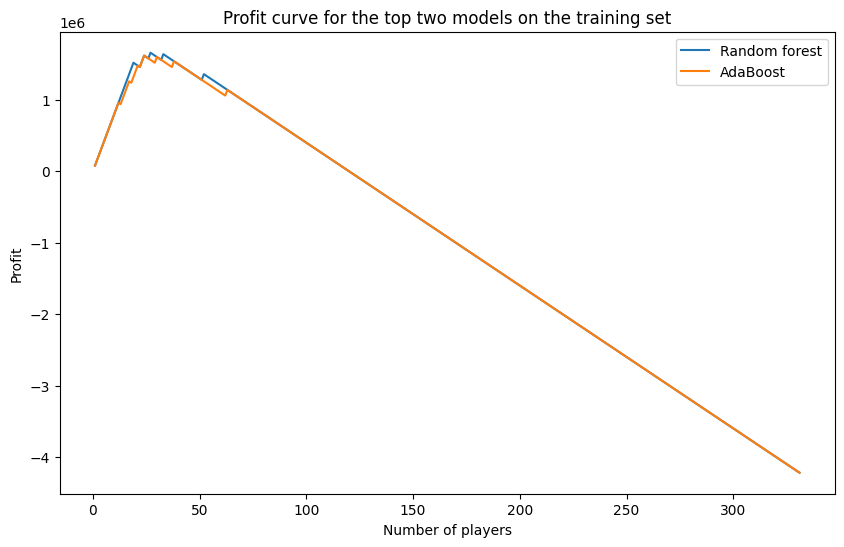

In [30]:
# Plot the profit curve for the top two models
plt.figure(figsize=(10, 6))
plt.plot(list(profit_rf_train.keys()), list(profit_rf_train.values()), label='Random forest')
plt.plot(list(profit_ada_train.keys()), list(profit_ada_train.values()), label='AdaBoost')
plt.xlabel('Number of players')
plt.ylabel('Profit')
plt.title('Profit curve for the top two models on the training set')
plt.legend()
plt.show()

In conclusion, random forest is still the best model (with the highest profit) when fitting on a split training set. We will see if this observation continues to hold true on the test set.

**4.3 Using the model selected in 4.2,  we will formulate clearly the investment strategy we will use to decide which players to invest in.**


The random forest model resulted in a ROC AUC score of 0.999

The optimal parameters for the random forest model are: 'max_depth': 4, 'max_features': 1, 'n_estimators': 50

The optimal probability threshold for the random forest model we found using the training set was 0.349

The adaBoost model resulted in a ROC AUC score of 0.996

The optimal parameters for the adaBoost model are: 'algorithm': 'SAMME', 'learning_rate': 0.4, 'n_estimators': 20

The optimal probability threshold for the adaBoost model we found using the training set was 0.535

**4.4 We deploy our strategy to the test set.**

In [31]:
# Random forest
# We use cross_val_predict to get the predicted probabilities for each player in the test set
rf_y_pred_test = cross_val_predict(rf_best_train, X_test2, y_test2, cv=folds, method='predict_proba')
# Create a dataframe with the acutal potential and the predicted probabilities
df_rf_prob_test = pd.DataFrame({'Actual': y_test2, 'Predicted': rf_y_pred_test[:,1], 'Player': X_test2.index})
# Sort the dataframe by the predicted probabilities
df_rf_prob_test = df_rf_prob_test.sort_values(by='Predicted', ascending=False)

In [32]:
# AdaBoost
# We use cross_val_predict to get the predicted probabilities for each player in the test set
ada_y_pred_test = cross_val_predict(ada_best_train, X_test, y_test, cv=folds, method='predict_proba')
# Create a dataframe with the acutal potential and the predicted probabilities
df_ada_prob_test = pd.DataFrame({'Actual': y_test, 'Predicted': ada_y_pred_test[:,1], 'Player': X_test.index})
# Sort the dataframe by the predicted probabilities
df_ada_prob_test = df_ada_prob_test.sort_values(by='Predicted', ascending=False)

In [33]:
# Random forest
# Use dictionaries to store profits
profit_rf_test = {}
size = 0
profit = 0
for index, row in df_rf_prob_test.iterrows():
  size += 1
  if(row[0]):
    profit += 80000
    profit_rf_test[size] = profit
  else:
    profit -= 20000
    profit_rf_test[size] = profit

#What is the optimal threshold that maximizes profit?
#Sort the random forest model by profit
profit_rf_test_sorted = sorted(profit_rf_test.items(), key=lambda x: x[1], reverse=True)
#Get the number of targets that maximizes profit
rf_highest_player_test = profit_rf_test_sorted[0][0]
#The probability threshold
prob_thresh_rf_test = df_rf_prob_test.iloc[rf_highest_player_test-1][1]

print('If we use the random forest model to predict the future potential of the players in the test set, we can maximize the profit by selecting the top', rf_highest_player_test, 'players.')
print('The optimal probability threshold using the random forest model is', prob_thresh_rf_test)
# The resulting profit is
print('The resulting profit using the random forest model is', profit_rf_test_sorted[0][1])


# AdaBoost
# Use dictionaries to store profits
profit_ada_test = {}
size = 0
profit = 0
for index, row in df_ada_prob_test.iterrows():
  size += 1
  if(row[0]):
    profit += 80000
    profit_ada_test[size] = profit
  else:
    profit -= 20000
    profit_ada_test[size] = profit

#What is the optimal threshold that maximizes profit?
#Sort the adaBoost model by profit
profit_ada_test_sorted = sorted(profit_ada_test.items(), key=lambda x: x[1], reverse=True)
#Get the number of targets that maximizes profit
ada_highest_player_test = profit_ada_test_sorted[0][0]
#The probability threshold
prob_thresh_ada_test = df_ada_prob_test.iloc[ada_highest_player_test-1][1]

print('If we use the adaBoost model to predict the future potential of the players in the test set, we can maximize the profit by selecting the top', ada_highest_player_test, 'players.')
print('The optimal probability threshold using the adaBoost model is', prob_thresh_ada_test)
# The resulting profit is
print('The resulting profit using the adaBoost model is', profit_ada_test_sorted[0][1])

If we use the random forest model to predict the future potential of the players in the test set, we can maximize the profit by selecting the top 29 players.
The optimal probability threshold using the random forest model is 0.22389539196795036
The resulting profit using the random forest model is 1220000
If we use the adaBoost model to predict the future potential of the players in the test set, we can maximize the profit by selecting the top 21 players.
The optimal probability threshold using the adaBoost model is 0.46466201408835733
The resulting profit using the adaBoost model is 1180000


Text(0.5, 1.0, 'Profit curve for the top two models on the test set')

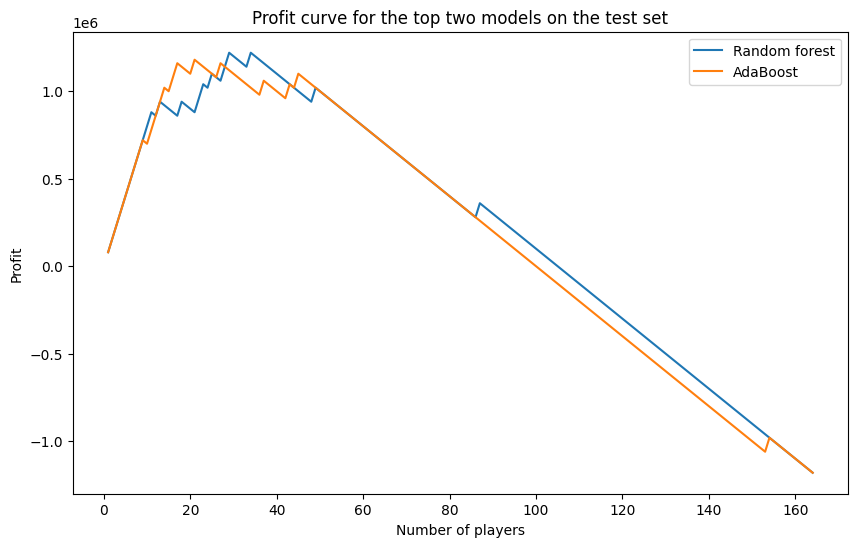

In [34]:
# Plot the profit curve for the top two models
plt.figure(figsize=(10, 6))
plt.plot(list(profit_rf_test.keys()), list(profit_rf_test.values()), label='Random forest')
plt.plot(list(profit_ada_test.keys()), list(profit_ada_test.values()), label='AdaBoost')
plt.xlabel('Number of players')
plt.ylabel('Profit')
plt.legend()
plt.title('Profit curve for the top two models on the test set')

In conclusion, we can see that even on the test set, the random forest model outperforms the adaBoost model with more profit.

**4.5 Print the list of players (along with their example number) we will invest in, and report our profit.**

In [35]:
# The players to select using the random forest model
print('The players to select using the random forest model are:')
print(df_rf_prob_test[df_rf_prob_test['Predicted'] >= prob_thresh_rf_test]['Player'].values)
# The highest profit we can make using the random forest model
print('The highest profit we can make using the random forest model is', profit_rf_test_sorted[0][1])

# The players to select using the adaBoost model
print('The players to select using the adaBoost model are:')
print(df_ada_prob_test[df_ada_prob_test['Predicted'] >= prob_thresh_ada_test]['Player'].values)
# The highest profit we can make using the adaBoost model
print('The highest profit we can make using the adaBoost model is', profit_ada_test_sorted[0][1])

The players to select using the random forest model are:
[ 87 353  73 114 228 397 347  14 287 394  80  24 204 330  10 310 320 209
 179 299 466 112 175 269 340  83 194 427 123]
The highest profit we can make using the random forest model is 1220000
The players to select using the adaBoost model are:
[228  73 397 394 114 209 353  80 123  24  14 347 204  87  10 427 287 290
  83 415 340]
The highest profit we can make using the adaBoost model is 1180000


## 5. For Competition

**5.1 Train on the entire sample data**

In [36]:
# Since we now know from the previous sections that random forest and adaBoost models are the top two models,
# we will elaborate on both models to see if we can further improve the performance of the models.

# Random forest
# We use the best random forest model we fitted in section 2, which used the entire sample data
# We use cross_val_predict to get the predicted probabilities for each player in the entire sample data
rf_y_pred = cross_val_predict(rf_best, X_After_Selection, y, cv=folds, method='predict_proba')
# Create a dataframe with the acutal potential and the predicted probabilities
df_rf_prob = pd.DataFrame({'Actual_Hall_of_Fame': y, 'Prob': rf_y_pred[:,1], 'Player': X_After_Selection.index})
# Sort the dataframe by the predicted probabilities
df_rf_prob = df_rf_prob.sort_values(by='Prob', ascending=False)

In [37]:
# AdaBoost
# We use the best adaBoost model we fitted in section 2, which used the entire sample data
# We use cross_val_predict to get the predicted probabilities for each player in the entire sample data
ada_y_pred = cross_val_predict(ada_best, X_After_Selection, y, cv=folds, method='predict_proba')
# Create a dataframe with the acutal potential and the predicted probabilities
df_ada_prob = pd.DataFrame({'Actual_Hall_of_Fame': y, 'Prob': ada_y_pred[:,1], 'Player': X_After_Selection.index})
# Sort the dataframe by the predicted probabilities
df_ada_prob = df_ada_prob.sort_values(by='Prob', ascending=False)

**5.2 Find the maximum possible profit for the top two models**

In [38]:
# After having predicted the probabilities for each player, we can now calculate the profit for each model

# Random forest
# Use dictionaries to store profits
profit_rf = {}
size = 0
profit = 0
for index, row in df_rf_prob.iterrows():
    size += 1
    if(row[0]):
        profit += 80000
        profit_rf[size] = profit
    else:
        profit -= 20000
        profit_rf[size] = profit

# What is the optimal threshold that maximizes profit?
# Sort the random forest model by profit
profit_rf_sorted = sorted(profit_rf.items(), key=lambda x: x[1], reverse=True)
# Get the number of targets that maximizes profit
rf_highest_player = profit_rf_sorted[0][0]
# The probability threshold
prob_thresh_rf = df_rf_prob.iloc[rf_highest_player-1][1]

print('If we use the random forest model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top', rf_highest_player, 'players.')
print('The optimal probability threshold using the random forest model is', prob_thresh_rf)
# The resulting profit is
print('The resulting profit using the random forest model is', profit_rf_sorted[0][1])


# AdaBoost
# Use dictionaries to store profits
profit_ada = {}
size = 0
profit = 0
for index, row in df_ada_prob.iterrows():
    size += 1
    if(row[0]):
        profit += 80000
        profit_ada[size] = profit
    else:
        profit -= 20000
        profit_ada[size] = profit

# What is the optimal threshold that maximizes profit?
# Sort the adaBoost model by profit
profit_ada_sorted = sorted(profit_ada.items(), key=lambda x: x[1], reverse=True)
# Get the number of targets that maximizes profit
ada_highest_player = profit_ada_sorted[0][0]
# The probability threshold
prob_thresh_ada = df_ada_prob.iloc[ada_highest_player-1][1]

print('If we use the adaBoost model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top', ada_highest_player, 'players.')
print('The optimal probability threshold using the adaBoost model is', prob_thresh_ada)
# The resulting profit is
print('The resulting profit using the adaBoost model is', profit_ada_sorted[0][1])

If we use the random forest model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top 52 players.
The optimal probability threshold using the random forest model is 0.25555555555555554
The resulting profit using the random forest model is 2960000
If we use the adaBoost model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top 63 players.
The optimal probability threshold using the adaBoost model is 0.38189306741890927
The resulting profit using the adaBoost model is 2940000


Text(0.5, 1.0, 'Profit curve for the top two models')

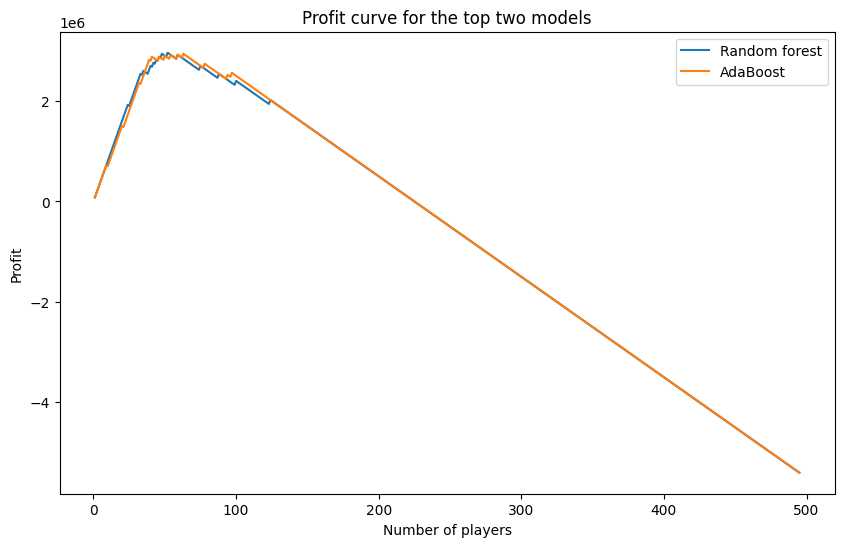

In [39]:
# Plot the profit curve for the top two models
plt.figure(figsize=(10, 6))
plt.plot(list(profit_rf.keys()), list(profit_rf.values()), label='Random forest')
plt.plot(list(profit_ada.keys()), list(profit_ada.values()), label='AdaBoost')
plt.xlabel('Number of players')
plt.ylabel('Profit')
plt.legend()
plt.title('Profit curve for the top two models')

In [40]:
# Just for additional information...

# The players to select using the random forest model
print('The players to select using the random forest model are:')
print(df_rf_prob[df_rf_prob['Prob'] >= prob_thresh_rf]['Player'].values)

# The players to select using the adaBoost model
print('The players to select using the adaBoost model are:')
print(df_ada_prob[df_ada_prob['Prob'] >= prob_thresh_ada]['Player'].values)

The players to select using the random forest model are:
[ 96 228  35 274 114 209 176 355 464 353 301 309  38 397 394   6 482  73
  87  53 347 487 168  14  24 480 143  80 104 359 142 287 392  46 204  10
 478 350 244 112  12 123 341 427 492 175  47 484 181 330  78 340 214]
The players to select using the adaBoost model are:
[228  73 114 301  96 355 274 464   6  24 309 176 143 209 482 397 394  87
 359 353  46 347 392  53 487 168  35  14  38 104  80 480 492 112 142 287
 204 427 244  10 175 179 471 214 478 123 350 435 341 437 466 354 467 484
  47 247  98 120 475 351 415 269 340]


**5.3 Futher improve the best model (random forest) we found**

In [41]:
# Let's try to improve the best model, random forest, by further tuning the hyperparameters
rf2 = RandomForestClassifier(n_estimators=100, n_jobs=-1, random_state=3)
# Using GridSearchCV to find the best parameters for the random forest
rf2_params = {'n_estimators': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100], 'max_features': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10], 'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10],
              'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10]}
# Using GridSearchCV to find the best parameters for the random forest based on ROC AUC
rf2_grid_roc = GridSearchCV(rf2, rf2_params, cv=folds, scoring='roc_auc')
rf2_grid_roc.fit(X_After_Selection2, y)

# The best parameters
print('The best parameters for the random forest model are', rf2_grid_roc.best_params_)
# The best score
print('The best score for the random forest model is', rf2_grid_roc.best_score_)

The best parameters for the random forest model are {'max_depth': 7, 'max_features': 9, 'min_samples_split': 3, 'n_estimators': 90}
The best score for the random forest model is 0.9926666666666668


We will use a greedy approach to further refine our model while saving time.

In [42]:
# Refined random forest model
rf2_best = RandomForestClassifier(n_estimators=90, max_features=9, max_depth=7, min_samples_split=3, random_state=3)
# Using cross_val_predict to get the predicted probabilities for each player in the entire sample data
rf2_y_pred = cross_val_predict(rf2_best, X_After_Selection2, y, cv=folds, method='predict_proba')
# Create a dataframe with the acutal potential and the predicted probabilities
df_rf2_prob = pd.DataFrame({'Actual_Hall_of_Fame': y, 'Prob': rf2_y_pred[:,1], 'Player': X_After_Selection2.index})
# Sor thte dataframe by the predicted probabilities
df_rf2_prob = df_rf2_prob.sort_values(by=['Prob'], ascending=False)

# Use dictionaries to store profits
profit_rf2 = {}
size = 0
profit = 0
for index, row in df_rf2_prob.iterrows():
    size += 1
    if(row[0]):
        profit += 80000
        profit_rf2[size] = profit
    else:
        profit -= 20000
        profit_rf2[size] = profit

# What is the optimal threshold that maximizes profit?
# Sort the random forest model by profit
profit_rf2_sorted = sorted(profit_rf2.items(), key=lambda x: x[1], reverse=True)
# Get the number of targets that maximizes profit
rf2_highest_player = profit_rf2_sorted[0][0]
# The probability threshold
prob_thresh_rf2 = df_rf2_prob.iloc[rf2_highest_player-1][1]

print('If we use the refined random forest model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top', rf2_highest_player, 'players.')
print('The optimal probability threshold using the refined random forest model is', prob_thresh_rf2)
# The resulting profit is
print('The resulting profit using the refined random forest model is', profit_rf2_sorted[0][1])

If we use the refined random forest model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top 54 players.
The optimal probability threshold using the refined random forest model is 0.24407407407407405
The resulting profit using the refined random forest model is 3020000


Text(0.5, 1.0, 'Profit curve for the refined random forest model')

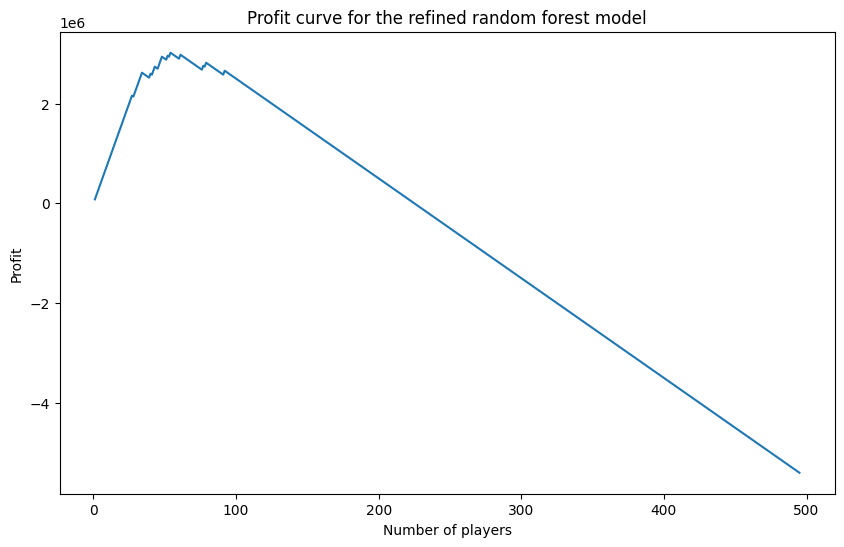

In [43]:
# Plot the profit curve for the refined random forest model
plt.figure(figsize=(10, 6))
plt.plot(list(profit_rf2.keys()), list(profit_rf2.values()), label='Refined random forest')
plt.xlabel('Number of players')
plt.ylabel('Profit')
plt.title('Profit curve for the refined random forest model')

We are able to futher develop our random forest model so that our optimal profit is increased to 3020000.

The best parameters for the random forest model are 'max_depth': 7, 'max_features': 9, 'min_samples_split': 3, 'n_estimators': 90

The best score for the random forest model is 0.9926666666666668

If we use the refined random forest model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top 54 players.

The optimal probability threshold using the refined random forest model is 0.24407407407407405

**5.4 Other popular models: neural networks**

Find the optimal learning rate

In [15]:
# We will see if we can do better with neural networks
# Import tensorflow
import tensorflow as tf

# Use stratified k-fold cross validation to find the best learning rate for the neural network model
xshape = (X_transformed.shape[1],)
learning_rates = [0.001, 0.01, 0.02, 0.03, 0.04, 0.05]
best_rates_count = {}
rates_scores = {}
for i in range(10):
    for rate in learning_rates:
        # 10 folds cross validation using stratified k fold
        skf = StratifiedKFold(n_splits=10, random_state=3, shuffle=True)
        skf.get_n_splits(X_transformed, y)
        avg_val_acc = 0
        for train_index, test_index in skf.split(X_transformed, y):
            X_train_NN, X_val_NN = X_transformed.iloc[train_index], X_transformed.iloc[test_index]
            y_train_NN, y_val_NN = y.iloc[train_index], y.iloc[test_index]
            #Sequential model, layers added one at a time
            #Dense means the nodes are fully connected to the previous layer
            NNmodel_adam = tf.keras.models.Sequential([
                # The first hidden layer, with input shape
                tf.keras.layers.Dense(128,activation=tf.nn.relu,input_shape=xshape),
                # The next hidden layer
                tf.keras.layers.Dense(64,activation=tf.nn.relu),
                # The output layer
                tf.keras.layers.Dense(1,activation=tf.nn.sigmoid)])
            NNmodel_adam.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=rate),
                            loss='binary_crossentropy',
                            metrics=['accuracy'])
            # We use an epoch of 10% of the training set to help prevent overfitting
            # We use a batch size of 10% of the training set to help prevent overfitting
            NNmodel_adam.fit(X_train_NN,y_train_NN,validation_data=(X_val_NN,y_val_NN),epochs=int(len(X_train_NN)/10),batch_size=int(len(X_train_NN)/10),verbose=0)
            avg_val_acc += NNmodel_adam.evaluate(X_val_NN,y_val_NN,verbose=0)[1]
        rates_scores[rate] = avg_val_acc/10
    # Sort the dictionary by average validation accuracy
    rates_scores_sorted = sorted(rates_scores.items(), key=lambda x: x[1], reverse=True)
    # The best learning rate
    best_rate_current = rates_scores_sorted[0][0]
    # Add the count of the highest rate in the best_rates_count dictionary
    if best_rate_current in best_rates_count:
        best_rates_count[best_rate_current] += 1
    else:
        best_rates_count[best_rate_current] = 1
    print(best_rates_count)
best_rate = max(best_rates_count, key=best_rates_count.get)
print('The best learning rate for the neural network model is', best_rate)

{0.001: 1}
{0.001: 1, 0.01: 1}
{0.001: 2, 0.01: 1}
{0.001: 3, 0.01: 1}
{0.001: 4, 0.01: 1}
{0.001: 4, 0.01: 1, 0.02: 1}
{0.001: 4, 0.01: 2, 0.02: 1}
{0.001: 5, 0.01: 2, 0.02: 1}
{0.001: 5, 0.01: 3, 0.02: 1}
{0.001: 5, 0.01: 3, 0.02: 1, 0.03: 1}
The best learning rate for the neural network model is 0.001


Find the best neural networks model using grid search (10 folds cross validation)

In [18]:
# import tensorflow
import tensorflow as tf
# import scikeras
from scikeras.wrappers import KerasClassifier

# create model
xshape = (X_transformed.shape[1],)
def create_model(dropout_rate, weight_constraint, neurons, activation='relu', optimizer='adam', init_mode='uniform'):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Dense(neurons, input_shape=xshape, activation=activation, kernel_constraint=tf.keras.constraints.MaxNorm(weight_constraint), kernel_initializer=init_mode))
    model.add(tf.keras.layers.Dropout(dropout_rate))
    model.add(tf.keras.layers.Dense(neurons, activation=activation, kernel_constraint=tf.keras.constraints.MaxNorm(weight_constraint), kernel_initializer=init_mode))
    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    return model

# use grid search to find the best parameters for the neural network model
batch_size = [10, 20, 40, 60, 80, 100]
epochs = [10, 50, 100]
momentum = [0.0, 0.2, 0.4, 0.6, 0.8, 0.9]
init_mode = ['uniform', 'lecun_uniform', 'normal', 'zero', 'glorot_normal', 'glorot_uniform', 'he_normal', 'he_uniform']
activation = ['softmax', 'softplus', 'softsign', 'relu', 'tanh', 'sigmoid', 'hard_sigmoid', 'linear']
# the weight constraint is used to limit the range of the weights, it can be used to prevent overfitting by forcing the weights to be small values 
weight_constraint = [1.0, 2.0, 3.0, 4.0, 5.0]
# dropout_rate is used to prevent overfitting, it randomly drops nodes from the neural network during training to prevent them from being too dependent on each other
dropout_rate = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]
# nuber of neurons
neurons = [8, 16, 32, 64, 128, 256]
param_grid = dict(batch_size=batch_size, epochs=epochs, optimizer__momentum=momentum, model__init_mode=init_mode, \
                  model__activation=activation, model__dropout_rate=dropout_rate, model__weight_constraint=weight_constraint, model__neurons=neurons)
# we will use the best learning rate (0.001) we found earlier
model = KerasClassifier(model=create_model, optimizer__learning_rate = 0.001, verbose=0, random_state=3)
# grid search with 10-fold cross validation, another measure to prevent overfitting
grid_NN = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=folds, scoring='roc_auc')
# fit the best neural network model found by grid search to the entire sample
grid_result = grid_NN.fit(X_transformed, y)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

c:\Users\Jack\AppData\Local\Programs\Python\Python310\lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Predict using the best neural networks model found with grid search

In [ ]:
# Use the best grid search model to predict the probabilities of each player being a Hall of Famer
import copy
df_NNmodel_grid_prob = copy.deepcopy(y)
df_NNmodel_grid_prob = df_NNmodel_grid_prob.to_frame()
df_NNmodel_grid_prob['prob'] = 0

# Use cross_val_predict to get the probabilities of each player being a Hall of Famer
grid_NN_pred = cross_val_predict(grid_result.best_estimator_, X_transformed, y, cv=folds, method='predict_proba')
df_NNmodel_grid_prob['prob'] = grid_NN_pred[:,1]

# Sort the dataframe by the probabilities
df_NNmodel_grid_prob = df_NNmodel_grid_prob.sort_values(by=['prob'], ascending=False)

In [ ]:
# Use dictionaries to store profits
profit_NN = {}
size = 0
profit = 0
for index, row in df_NNmodel_grid_prob.iterrows():
    size += 1
    if row[0]:
        profit += 80000
        profit_NN[size] = profit
    else:
        profit -= 20000
        profit_NN[size] = profit

# What is the optimal threshold that maximizes profit?
# Sort the neural network model by profit
profit_NN_sorted = sorted(profit_NN.items(), key=lambda x: x[1], reverse=True)
# Get the number of targets that maximizes profit
NN_highest_player = profit_NN_sorted[0][0]
# The probability threshold
prob_thresh_NN = df_NNmodel_grid_prob.iloc[(NN_highest_player-1),1]
print('If we use the neural network model to predict the future potential of the players on the entire sample data, we can maximize the profit by selecting the top', NN_highest_player, 'players.')
print('The optimal probability threshold using the neural network model is', prob_thresh_NN)
# The resulting profit is
print('The resulting profit using the neural network model is', profit_NN_sorted[0][1])

In [ ]:
# Plot the profit curve for the neural network model
plt.figure(figsize=(10, 6))
plt.plot(list(profit_NN.keys()), list(profit_NN.values()))
plt.xlabel('Number of players')
plt.ylabel('Profit')
plt.title('Profit curve for the neural network model')

# The players to select using the neural network model
print('The players to select using the neural network model are:')
print(df_NNmodel_grid_prob[df_NNmodel_grid_prob['prob'] >= prob_thresh_NN].index)

**5.5 Conclusion**

A problem with neural networks is that it is prone to overfitting. It is possible to perform GridSearchCV (10-fold cross-validation) for neural networks using the KerasClassifier from the SciKeras library. With the KerasClassifier, cross_val_predict (10 folds) can also be performed on the neural networks model like the rest of the scikit-learn models to limit overfitting.

To further prevent overfitting, a dropout rate and weight constraint are included in the model. By dropping out neurons randomly, the network becomes less sensitive to the precise details of individual neurons and learns more general features that can be useful for different inputs. The addition of a weight constraint makes the model's capacity limited, causing it to become less prone to overfitting.

In conclusion, although the neural networks model is, in theory, an advanced model for predicting whether an NBA player will be inducted into the Hall of Fame or not, it is computationally expensive. In my case, I am unable to finish running the GridSearchCV function even after a few hundred minutes. Therefore, if computational power is an issue, it is better to use the random forest model I found above. The random forest model resulted in a profit of $3020000 with a ROC AUC score of 0.9927.

## Attribute Descriptions

Field | Description
------|------------
league| N = National Basketball Association (NBA); A = American Basketball Association (ABA)
games|games played
minutes|minutes played
pts|points
offReb|offensive rebounds
defReb|defensive rebounds
reb|rebounds
asts|assists
stl|steals* (see below)
blk|blocks* (see below)
turnover|turnovers* (see below)
pf|Personal Fouls
fga|field goals attempted
fgm|field goals made
fta|free throws attempted
ftm|free throws made
tpa|three pointers attempted* (see below)
tpm|three pointers made* (see below)
totalSeasons|Total number of seasons played. This value is calculated as follows: "lastSeason - firstSeason + 1"
position|C = Center; F = Forward; G = Guard
firstSeason|First season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season). 
lastSeason|Last season played. The year corresponds to the first year of the season (i.e. a value of 2000 represents the 2000-2001 season). Note that 2004 (2004-2005 season) is the last year for which there is data. 
careerEnded|Boolean field for if the player's career has ended (1 if career has ended, 0 otherwise). This field was calculated as follows: if the "lastSeason" field is earlier than 2004, the value is 1, otherwise 0. Note that this calculation naively assumes that no players retired at the end of the 2004  season.
yrsRetired2004|The number of seasons that a player has been retired as of the 2004-2005 season.
class|A Boolean field showing whether or not a player was inducted to the Basketball Hall of Fame (HoF) as a player. This field has value 1 if the player has been inducted, and 0 otherwise.




* The NBA did not have three point shots until 1979
* Steals, Blocks and Turnovers were not recorded in the NBA until 1973